## ML_LAB05
## DECISION TREES AND ENSEMBLE METHODS
### LAKSHITA SETHI
### 21BDA54

In [51]:
import numpy as np
import pandas as pd 
import os
from pandas import read_csv
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Lets load the dataset and sample some
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = read_csv('/Users/lakshitasethi/Downloads/housing.csv', header=None, delimiter=r"\s+", names=column_names)

In [5]:
print(data.head(5))

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [6]:
# Dimension of the dataset
print(np.shape(data))

(506, 14)


In [7]:
# Let's summarize the data to see the distribution of data
print(data.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

Let's plot the dataset and see interesting trends/stats.

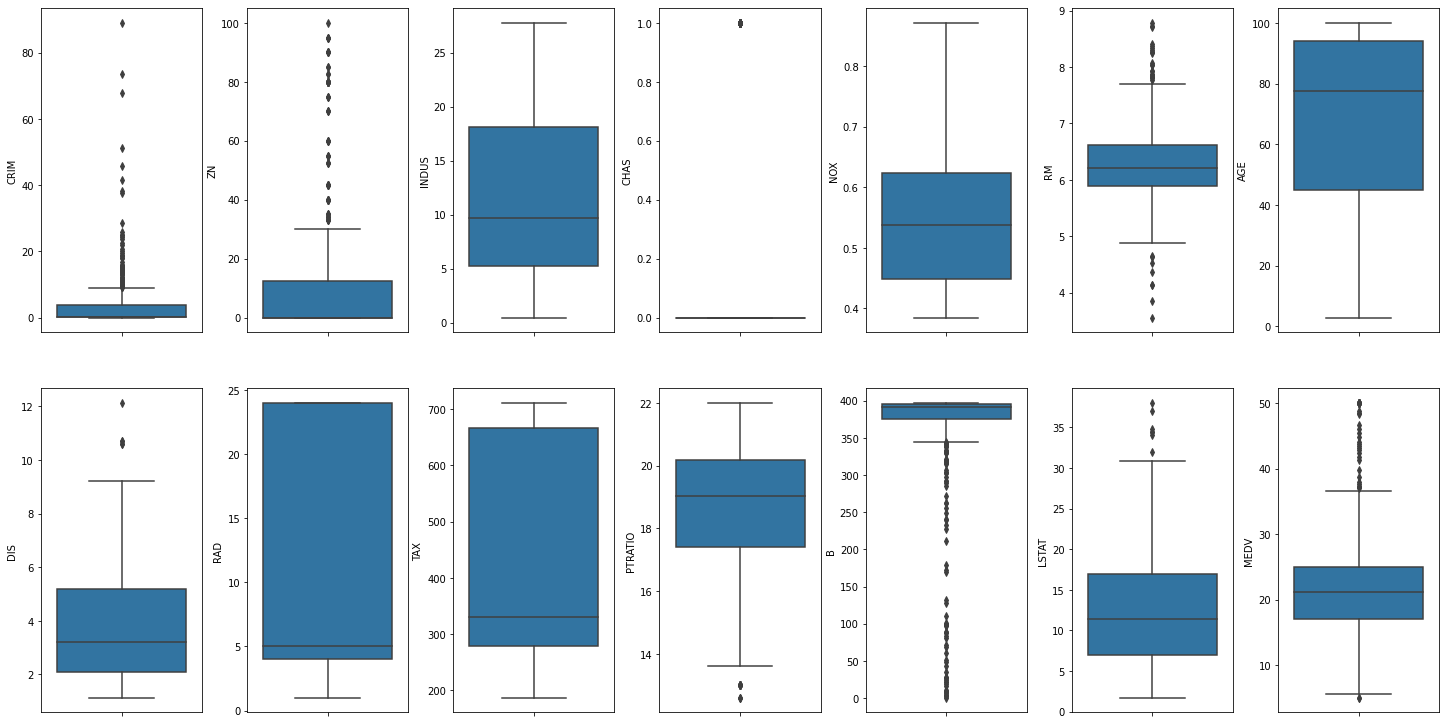

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Columns like CRIM, ZN, RM, B seems to have outliers. Let's see the outliers percentage in every column.

In [9]:
    for k, v in data.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))
    
    

Column CRIM outliers = 13.04%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


Let's remove MEDV outliers (MEDV = 50.0) before plotting more distributions

In [10]:
data = data[~(data['MEDV'] >= 50.0)]
print(np.shape(data))

(490, 14)


Let's see how these features plus MEDV distributions looks like

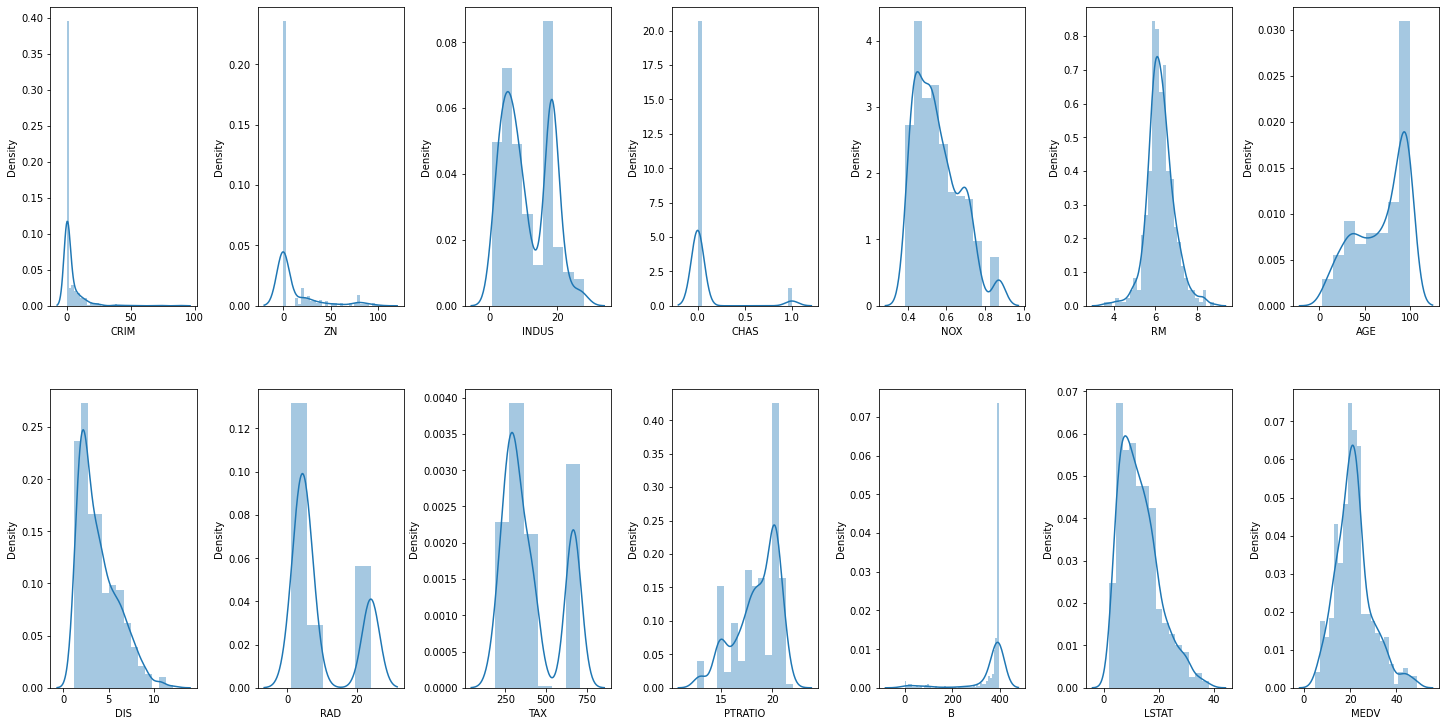

In [50]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

The histogram also shows that columns CRIM, ZN, B has highly skewed distributions. Also MEDV looks to have a normal distribution (the predictions) and other colums seem to have norma or bimodel ditribution of data except CHAS (which is a discrete variable).

Now let's plot the pairwise  correlation on data.

<AxesSubplot:>

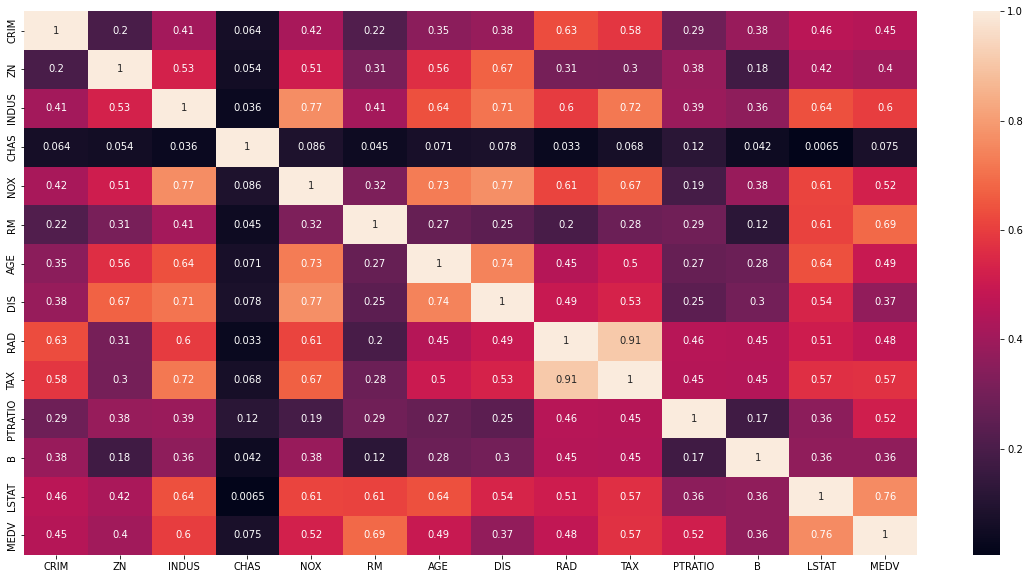

In [12]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),  annot=True)

From correlation matrix, we see TAX and RAD are highly correlated features. The columns LSTAT, INDUS, RM, TAX, NOX, PTRAIO has a correlation score above 0.5 with MEDV which is a good indication of using as predictors. Let's plot these columns against MEDV. 

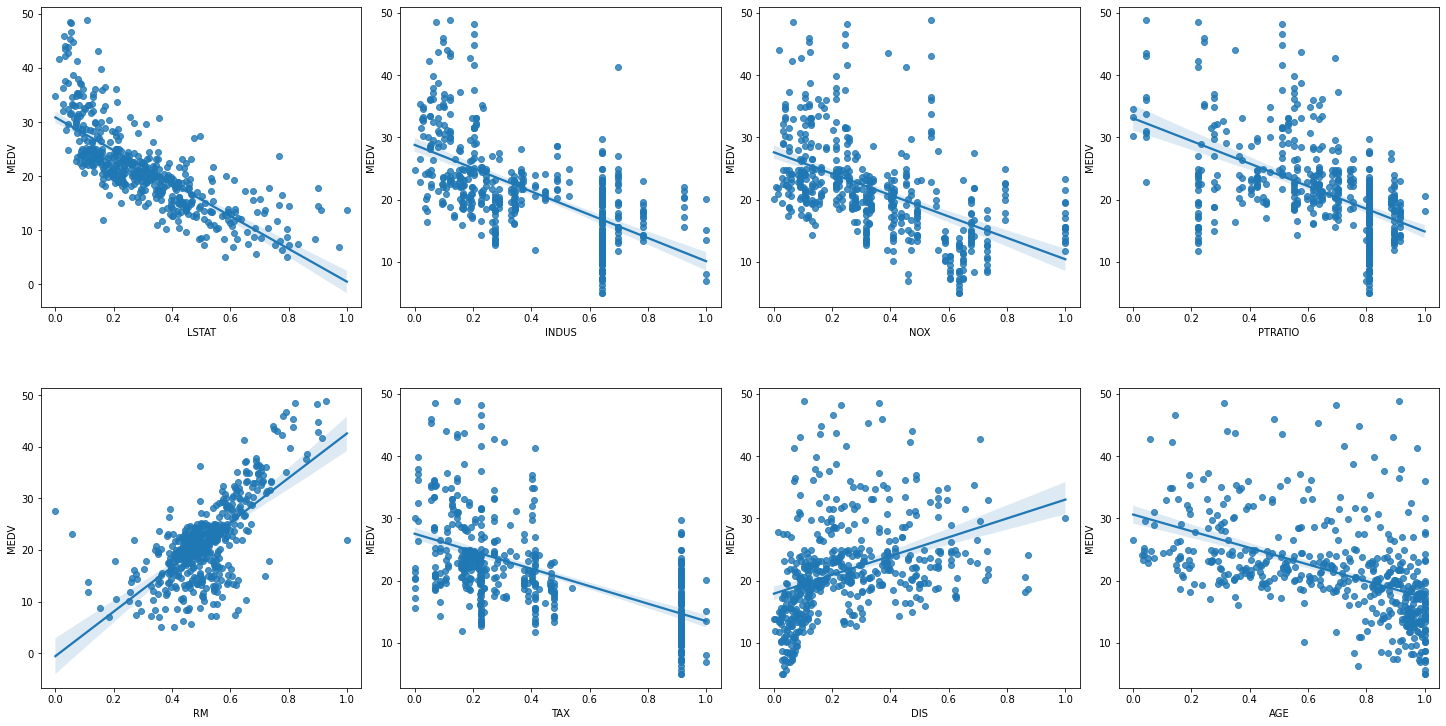

In [13]:
from sklearn import preprocessing
# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data.loc[:,column_sels]
y = data['MEDV']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


So with these analsis, we may try predict MEDV with 'LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE' features. Let's try to remove the skewness of the data trough log transformation.



In [14]:
y =  np.log1p(y)
for col in x.columns:
    if np.abs(x[col].skew()) > 0.3:
        x[col] = np.log1p(x[col])

Let's try Linear, Ridge Regression on dataset first.

In [15]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np

In [16]:
l_regression = linear_model.LinearRegression()
kf = KFold(n_splits=10)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scores = cross_val_score(l_regression, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

scores_map = {}
scores_map['LinearRegression'] = scores
l_ridge = linear_model.Ridge()
scores = cross_val_score(l_ridge, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['Ridge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -0.04 (+/- 0.04)
MSE: -0.04 (+/- 0.04)


In [17]:
# Lets try polinomial regression with L2 with degree for the best fit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

model = make_pipeline(PolynomialFeatures(degree=3), linear_model.Ridge())
scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['PolyRidge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -0.03 (+/- 0.03)


The Liner Regression with and without L2 regularization does not make significant difference is MSE score. However polynomial regression with degree=3 has a better MSE. Let's try some non prametric regression techniques: SVR with kernal rbf, DecisionTreeRegressor, KNeighborsRegressor etc.

In [19]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
scores = cross_val_score(svr_rbf, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['SVR'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -0.04 (+/- 0.03)


In [20]:
from sklearn.tree import DecisionTreeRegressor

desc_tr = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(desc_tr, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['DecisionTreeRegressor'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -0.05 (+/- 0.04)


In [21]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=7)
scores = cross_val_score(knn, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['KNeighborsRegressor'] = scores
print("KNN Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

KNN Accuracy: -0.04 (+/- 0.02)


Compared to three models which are shosen through grid search, SVR performes better. Let's try an ensemble method finally.

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(alpha=0.9,learning_rate=0.05, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100, random_state=30)
scores_map['GradientBoostingRegressor'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


MSE: -0.04 (+/- 0.02)


Let's plot k-fold results to see which model has better distribution of results. Let's have a look at the MSE distribution of these models with k-fold=10

<AxesSubplot:>

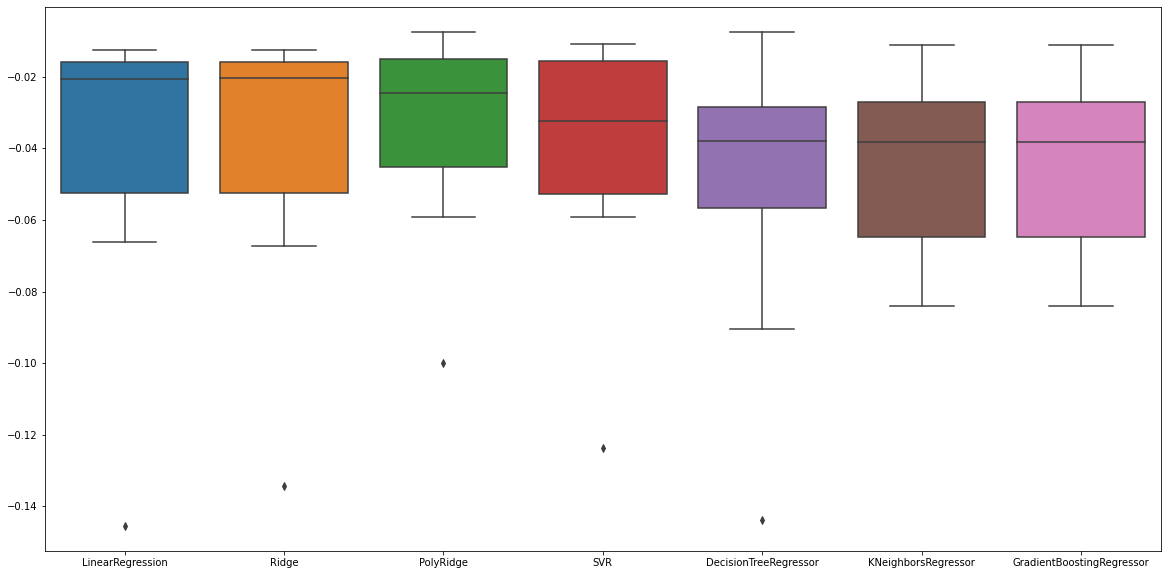

In [23]:
plt.figure(figsize=(20, 10))
scores_map = pd.DataFrame(scores_map)
sns.boxplot(data=scores_map)

The models SVR and GradientBoostingRegressor show better performance with -11.62 (+/- 5.91) and -12.39 (+/- 5.86).

In [26]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

In [27]:
# defining x and y values for training, validation, and test sets. 

target = 'TAX'
features = train.columns.drop(target)

x_train = train[features]
y_train = train[target]
x_test = test[features]
y_test = test[target]

In [28]:
#build the model, we import decision tree regressor from SKLEARN

from sklearn.tree import DecisionTreeRegressor

In [29]:
dt = DecisionTreeRegressor(random_state=42)

In [30]:
# fit the tree model through the x_training data

dt.fit(x_train, y_train)

DecisionTreeRegressor(random_state=42)

In [32]:
y_pred_dt = dt.predict(x_test)

In [33]:
# get error metrics to evaluate model. 

from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, y_pred_dt)
mae

12.785714285714286

In [34]:
# r2 score using sklearn metrics r2 score library
r2 = r2_score(y_test, y_pred_dt)
r2

0.9618987104623444

In [36]:
# r2 score using decision tree regressor scoring method. 
dt.score(x_test, y_test)

0.9618987104623444

### Hypermetre Tuning

In [42]:
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 50],
              }


grid_cv_dt = GridSearchCV(dt, param_grid, cv=5)

grid_cv_dt.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8],
                         'max_leaf_nodes': [5, 20, 50],
                         'min_samples_leaf': [20, 40, 100],
                         'min_samples_split': [10, 20, 40]})

In [45]:
print("R-Squared::{}".format(grid_cv_dt.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dt.best_params_))

R-Squared::0.8914568630400342
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [46]:
df = pd.DataFrame(data=grid_cv_dt.cv_results_)

In [49]:
# Checking the training model scores
r2_scores = cross_val_score(grid_cv_dt.best_estimator_, x_train, y_train, cv=10)
mse_scores = cross_val_score(grid_cv_dt.best_estimator_, x_train, y_train, cv=10,scoring='neg_mean_squared_error')

print("avg R-squared::{:.3f}".format(np.mean(r2_scores)))
print("MSE::{:.3f}".format(np.mean(mse_scores)))

avg R-squared::0.901
MSE::-2817.904


#### We notice that earlier R-squared was 96%, which might have been a case of overfitting, so applying GridSearchCV, we get a lesser yet better R-squared value of 90.1%.

#### Ref. https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset/notebook